This dataset shows the NYC taxi demand from 2014–07–01 to 2015–01–31 with an observation every half hour. In this period 5 anomalies are present, in term of deviation from a normal behavior. They occur respectively during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm.
goal is to detect the anomalies in the best way possible.

In [1]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)


Using TensorFlow backend.


Python:  3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
pandas:  0.24.2
numpy:  1.16.4
seaborn:  0.9.0
matplotlib:  3.1.0
sklearn:  0.21.2
Keras:  2.2.4
Tensorflow:  1.13.1


In [2]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
        plt.figure(figsize=(10, 8))
        plt.plot(error, marker='o', ms=3.5, linestyle='',
                 label='Point')

        plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="r", zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

In [3]:

tensorlogs = ["art_daily_no_noise", #0
              "art_daily_nojump", #1
              "art_daily_jumpsdown",#2 
              "art_daily_perfect_square_wave", #3 
              "art_increase_spike_density",  #4
              "art_load_balancer_spikes",  #5
              "ambient_temperature_system_failure", #6 
              "nyc_taxi",  #7
              "ec2_cpu_utilization", #8
              "rds_cpu_utilization"] #9 

dataFilePaths = ['data/art_daily_no_noise.csv',
                 'data/art_daily_nojump.csv',
                 'data/art_daily_jumpsdown.csv',
                 'data/art_daily_perfect_square_wave.csv',
                 'data/art_increase_spike_density.csv',
                 'data/art_load_balancer_spikes.csv',
                 'data/ambient_temperature_system_failure.csv',
                 'data/nyc_taxi.csv',
                 'data/ec2_cpu_utilization.csv',
                 'data/rds_cpu_utilization.csv']




In [4]:
i = 7

tensorlog = tensorlogs[i]
dataFilePath = dataFilePaths[i]
print("tensorlog: ", tensorlog)
print("dataFilePath: ", dataFilePath)

tensorlog:  nyc_taxi
dataFilePath:  data/nyc_taxi.csv


In [5]:
df = pd.read_csv(filepath_or_buffer=dataFilePath, header=0, sep=',')
print('Shape:' , df.shape[0])
print('Head:')
print(df.head(5))


Shape: 10320
Head:
             timestamp  value
0  2014-07-01 00:00:00  10844
1  2014-07-01 00:30:00   8127
2  2014-07-01 01:00:00   6210
3  2014-07-01 01:30:00   4656
4  2014-07-01 02:00:00   3820


             timestamp  value            Datetime
0  2014-07-01 00:00:00  10844 2014-07-01 00:00:00
1  2014-07-01 00:30:00   8127 2014-07-01 00:30:00
2  2014-07-01 01:00:00   6210 2014-07-01 01:00:00


Text(0.5, 1.0, 'Time Series of value by date time')

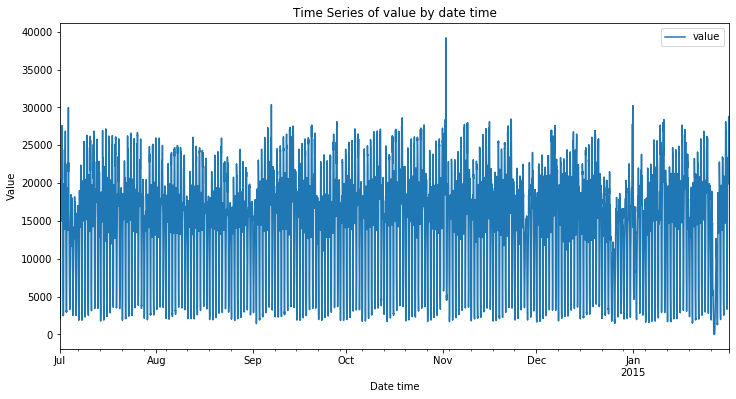

In [6]:
df['Datetime'] = pd.to_datetime(df['timestamp'])
print(df.head(3))
df.shape
df.plot(x='Datetime', y='value', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

In [8]:
df.value.describe()

count    10320.000000
mean     15137.569380
std       6939.495808
min          8.000000
25%      10262.000000
50%      16778.000000
75%      19838.750000
max      39197.000000
Name: value, dtype: float64

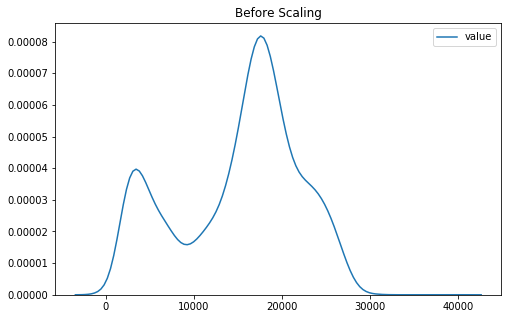

In [9]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['value'], ax=ax1)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])),columns=['value'])
print('Shape:' , df.shape[0])
df.head(5)

Shape: 10320


,timestamp,value,Datetime,scaled_value
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00,0.276506
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00,0.207175
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00,0.158259
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00,0.118605
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00,0.097272


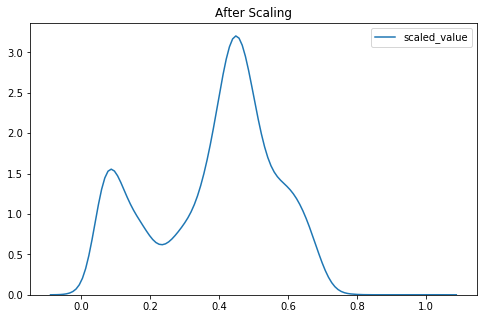

In [11]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)

In [12]:
df.head(5)

,timestamp,value,Datetime,scaled_value
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00,0.276506
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00,0.207175
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00,0.158259
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00,0.118605
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00,0.097272


In [13]:
time_steps = 48
metric = 'mean_absolute_error'

model = Sequential()
model.add(LSTM(units=32, activation='tanh', input_shape=(time_steps, 1), return_sequences=True))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[metric])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 48, 32)            4352      
_________________________________________________________________
dense_1 (Dense)              (None, 48, 1)             33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
sequence = np.array(df['scaled_value'])
print(sequence)
time_steps = 48
samples = len(sequence)
trim = samples % time_steps
subsequences = int(samples/time_steps)
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
print(sequence_trimmed.shape)

[0.27650616 0.20717548 0.1582587  ... 0.69664957 0.6783281  0.67059634]
10320 215
(215, 48, 1)


In [15]:
training_dataset = sequence_trimmed
print("training_dataset: ", training_dataset.shape)

batch_size=32
epochs=20

model.fit(x=training_dataset, y=training_dataset,
                       batch_size=batch_size, epochs=epochs,
                       verbose=1, validation_data=(training_dataset, training_dataset),
                       callbacks=[TensorBoard(log_dir='../logs/{0}'.format(tensorlog))])

training_dataset:  (215, 48, 1)
Instructions for updating:
Use tf.cast instead.
Train on 215 samples, validate on 215 samples
Epoch 1/20
215/215 [==============================] - 2s 9ms/step - loss: 0.1543 - mean_absolute_error: 0.1543 - val_loss: 0.1513 - val_mean_absolute_error: 0.1513
Epoch 2/20
215/215 [==============================] - 1s 5ms/step - loss: 0.1506 - mean_absolute_error: 0.1506 - val_loss: 0.1493 - val_mean_absolute_error: 0.1493
Epoch 3/20
215/215 [==============================] - 1s 5ms/step - loss: 0.1482 - mean_absolute_error: 0.1482 - val_loss: 0.1466 - val_mean_absolute_error: 0.1466
Epoch 4/20
215/215 [==============================] - 1s 5ms/step - loss: 0.1454 - mean_absolute_error: 0.1454 - val_loss: 0.1438 - val_mean_absolute_error: 0.1438
Epoch 5/20
215/215 [==============================] - 1s 5ms/step - loss: 0.1424 - mean_absolute_error: 0.1424 - val_loss: 0.1404 - val_mean_absolute_error: 0.1404
Epoch 6/20
215/215 [==============================] - 

In [16]:
import math
from sklearn.metrics import mean_squared_error

sequence = np.array(df['scaled_value'])
print(sequence)
time_steps = 48
samples = len(sequence)
trim = samples % time_steps
subsequences = int(samples/time_steps)
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
print(sequence_trimmed.shape)

testing_dataset = sequence_trimmed
print("testing_dataset: ", testing_dataset.shape)

testing_pred = model.predict(x=testing_dataset)
print("testing_pred: ", testing_pred.shape)

testing_dataset = testing_dataset.reshape((testing_dataset.shape[0]*testing_dataset.shape[1]), testing_dataset.shape[2])
print("testing_dataset: ", testing_dataset.shape)

testing_pred = testing_pred.reshape((testing_pred.shape[0]*testing_pred.shape[1]), testing_pred.shape[2])
print("testing_pred: ", testing_pred.shape)
errorsDF = testing_dataset - testing_pred
print(errorsDF.shape)
rmse = math.sqrt(mean_squared_error(testing_dataset, testing_pred))
print('Test RMSE: %.3f' % rmse)

[0.27650616 0.20717548 0.1582587  ... 0.69664957 0.6783281  0.67059634]
10320 215
(215, 48, 1)
testing_dataset:  (215, 48, 1)
testing_pred:  (215, 48, 1)
testing_dataset:  (10320, 1)
testing_pred:  (10320, 1)
(10320, 1)
Test RMSE: 0.083


In [17]:
#based on cutoff after sorting errors
dist = np.linalg.norm(testing_dataset - testing_pred, axis=-1)

scores =dist.copy()
print(scores.shape)
scores.sort()
cutoff = int(0.999 * len(scores))
print(cutoff)
#print(scores[cutoff:])
threshold= scores[cutoff]
print(threshold)

(10320,)
10309
0.3306469524381854


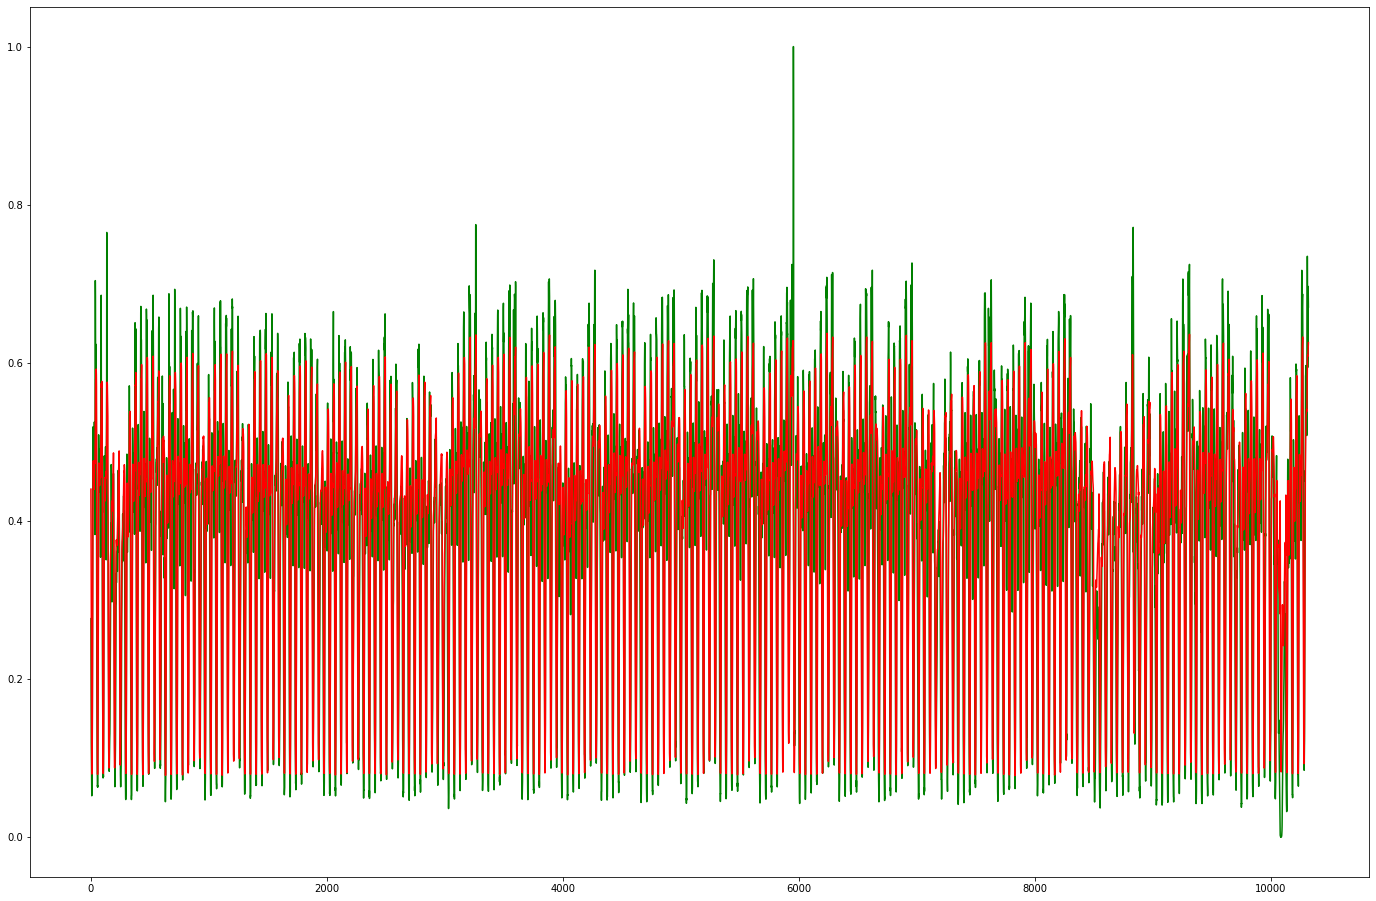

In [18]:
plt.figure(figsize=(24,16))
plt.plot(testing_dataset, color='green')
plt.plot(testing_pred, color='red')

In [19]:
#label the records anomalies or not based on threshold
z = zip(dist >= threshold, dist)

y_label=[]
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)
    

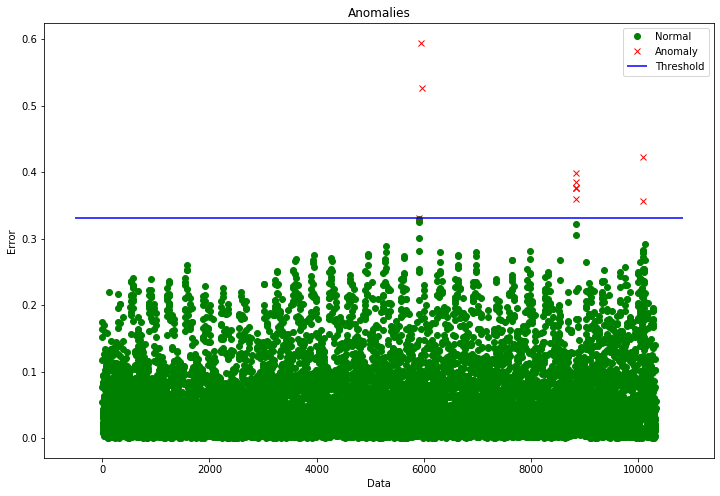

In [20]:
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

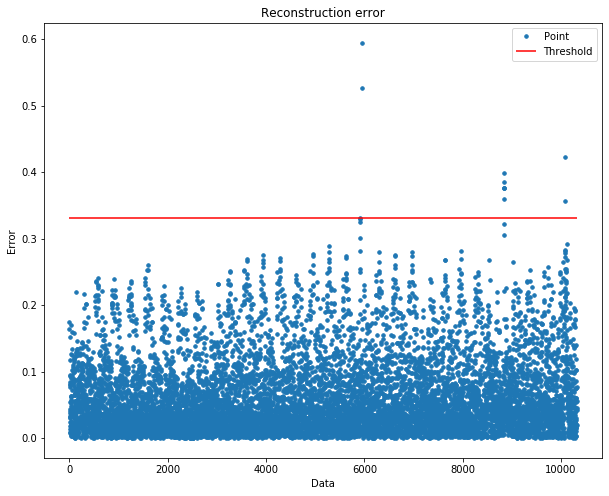

In [21]:
viz.draw_error(error, threshold)

In [22]:
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation': df['value'],
                    'error': error, 'anomaly': y_label})
adf.head(5)


,Datetime,observation,error,anomaly
0,2014-07-01 00:00:00,10844,0.163783,0
1,2014-07-01 00:30:00,8127,0.174832,0
2,2014-07-01 01:00:00,6210,0.152199,0
3,2014-07-01 01:30:00,4656,0.118035,0
4,2014-07-01 02:00:00,3820,0.076069,0


Text(0.5, 1.0, 'Time Series of value by date time')

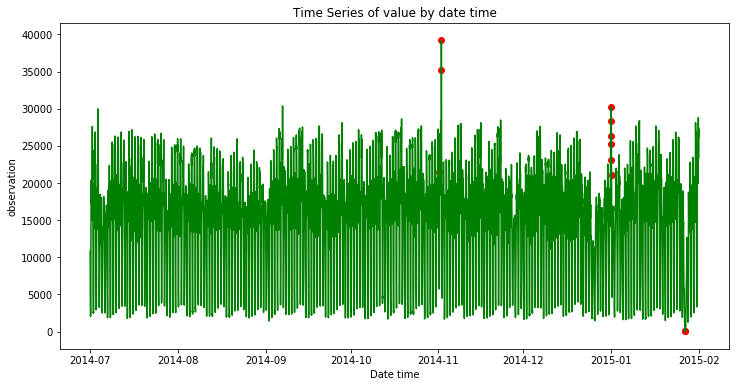

In [23]:
figure, axes = plt.subplots(figsize=(12, 6))
axes.plot(adf['Datetime'], adf['observation'], color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')